In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rdkit-pypi
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 3.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

import shap

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

from joblib import dump

**INITIAL STUDY : In this study we use a dataset composed of scmiles with a minimum PCE value of 15%.**

# DATA CONSTRUCTION

This involves generating descriptors for each type of molecule (acceptor, donor).

## FOR DONNORS

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/M1_OSCML_PROJECT_2025/M12024_DATA_OVER_15.csv")


In [ ]:
data

,Unnamed: 0,Mol_don,Mol_acc,PCE,Voc,Jsc,FF,SMILES_acc,SMILES_don,DOI
0,0,D18,S9TBO-F,17.17,0.838,28.19,0.749,CCCCCCCCCc3c(C=c2c(=O)c1cc(F)c(F)cc1c2=C(C#N)C...,CCCCCCC(CC1=CSC(C2=CC3=C(C4=C(C5=NSN=C53)C=C(S...,10.1002/adma.202202089
1,1,D18,BS3TSe-4F,18.48,0.828,29.40,0.759,CCCCCCCCCc3c(C=c2c(=O)c1cc(F)c(F)cc1c2=C(C#N)C...,CCCCCCC(CC1=CSC(C2=CC3=C(C4=C(C5=NSN=C53)C=C(S...,10.1002/adma.202202089
2,2,PM6,Y-BO-FCl,17.52,0.850,23.45,0.779,CCCCCCC(CCCC)CN7c3c(sc4c([C11])c(C=c2c(=O)c1cc...,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,10.1039/d1ee01832a
3,3,PM6,Y-BO-FBr,16.47,0.850,25.83,0.750,CCCCCCC(CCCC)Cn%12c4c3sc(C=c2c(=O)c1cc(Br)c(F)...,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,10.1039/d1ee01832a
4,4,PM6,PY-V-y,17.10,0.912,24.80,0.758,CC(C)(C)/C=C/c%12ccc%11c(=C(C#N)C#N)c(=Cc%10sc...,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,10.1002/adma.202200361
...,...,...,...,...,...,...,...,...,...,...
119,119,PBDBT-2F,Y6,16.09,0.820,26.22,0.749,CCCCCCCCCCCC1=C(SC2=C1SC1=C2N(CC(CC)CCCC)C2=C1...,[H]C1=CC2=C(S1)C(C3=CC(F)=C(CC(CC)CCCC)S3)=C4C...,http://dx.doi.org/10.1021/acsami.0c09123
120,121,PM6,PY-T-y,16.10,0.929,24.10,0.719,CC(C)(C)c%13ccc%12c(=C(C#N)C#N)c(=Cc%11sc9c(sc...,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,10.1002/adma.202200361
121,122,PTQ10,o-BTP-C6Ph,16.00,0.924,22.80,0.762,CCCCCCc1ccccc1c4c(C=c3c(=O)c2cc(F)c(F)cc2c3=C(...,[H]C1=C(F)C(F)=C(C2=CC=C([H])S2)C3=C1N=C(OCC(C...,10.1039/d0ee03506h
122,123,PBNT-BDD,Y6-BO,16.10,0.870,25.40,0.710,CCCCCCCCCCCc3c(C=c2c(=O)c1cc(F)c(F)cc1c2=C(C#N...,CCCCCCCCC(CN1B(C2=C(C3=CC4=C(C5=C(B(N4CC(CCCCC...,https://doi.org/10.1002/anie.202016265


In [ ]:
data = data.drop(columns="Unnamed: 0")

In [ ]:
data

,Mol_don,Mol_acc,PCE,Voc,Jsc,FF,SMILES_acc,SMILES_don,DOI
0,D18,S9TBO-F,17.17,0.838,28.19,0.749,CCCCCCCCCc3c(C=c2c(=O)c1cc(F)c(F)cc1c2=C(C#N)C...,CCCCCCC(CC1=CSC(C2=CC3=C(C4=C(C5=NSN=C53)C=C(S...,10.1002/adma.202202089
1,D18,BS3TSe-4F,18.48,0.828,29.40,0.759,CCCCCCCCCc3c(C=c2c(=O)c1cc(F)c(F)cc1c2=C(C#N)C...,CCCCCCC(CC1=CSC(C2=CC3=C(C4=C(C5=NSN=C53)C=C(S...,10.1002/adma.202202089
2,PM6,Y-BO-FCl,17.52,0.850,23.45,0.779,CCCCCCC(CCCC)CN7c3c(sc4c([C11])c(C=c2c(=O)c1cc...,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,10.1039/d1ee01832a
3,PM6,Y-BO-FBr,16.47,0.850,25.83,0.750,CCCCCCC(CCCC)Cn%12c4c3sc(C=c2c(=O)c1cc(Br)c(F)...,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,10.1039/d1ee01832a
4,PM6,PY-V-y,17.10,0.912,24.80,0.758,CC(C)(C)/C=C/c%12ccc%11c(=C(C#N)C#N)c(=Cc%10sc...,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,10.1002/adma.202200361
...,...,...,...,...,...,...,...,...,...
119,PBDBT-2F,Y6,16.09,0.820,26.22,0.749,CCCCCCCCCCCC1=C(SC2=C1SC1=C2N(CC(CC)CCCC)C2=C1...,[H]C1=CC2=C(S1)C(C3=CC(F)=C(CC(CC)CCCC)S3)=C4C...,http://dx.doi.org/10.1021/acsami.0c09123
120,PM6,PY-T-y,16.10,0.929,24.10,0.719,CC(C)(C)c%13ccc%12c(=C(C#N)C#N)c(=Cc%11sc9c(sc...,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,10.1002/adma.202200361
121,PTQ10,o-BTP-C6Ph,16.00,0.924,22.80,0.762,CCCCCCc1ccccc1c4c(C=c3c(=O)c2cc(F)c(F)cc2c3=C(...,[H]C1=C(F)C(F)=C(C2=CC=C([H])S2)C3=C1N=C(OCC(C...,10.1039/d0ee03506h
122,PBNT-BDD,Y6-BO,16.10,0.870,25.40,0.710,CCCCCCCCCCCc3c(C=c2c(=O)c1cc(F)c(F)cc1c2=C(C#N...,CCCCCCCCC(CN1B(C2=C(C3=CC4=C(C5=C(B(N4CC(CCCCC...,https://doi.org/10.1002/anie.202016265


In [ ]:
def canonical_smiles(smiles):
    canonical_smiles_list = []
    for smi in smiles:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            canonical_smiles_list.append(Chem.MolToSmiles(mol))
        else:
            print(f"Invalid SMILES: {smi}")
            canonical_smiles_list.append(None)
    return canonical_smiles_list




In [ ]:
# Function call
Canon_SMILES_don = canonical_smiles(data['SMILES_don'])

Invalid SMILES: CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5
Invalid SMILES: CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5


[11:30:00] SMILES Parse Error: syntax error while parsing: CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5
[11:30:00] SMILES Parse Error: Failed parsing SMILES 'CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5' for input: 'CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5'
[11:30:00] SMILES Parse Error: syntax error while parsing: CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5
[11:30:00] SMILES Parse Error: Failed parsing SMILES 'CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5' for input: 'CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5'


In [ ]:
data['TEMP_SMILES'] = Canon_SMILES_don

In [ ]:
def RDkit_descriptors(smiles):
    mols = []
    invalid_smiles = []
    indices = []  # List to store the index of each SMILES string
    for idx, i in enumerate(smiles):  # enumerate to get both index and value
        if pd.notna(i):  # Check if SMILES is not NaN
            mol = Chem.MolFromSmiles(i)
            if mol is None:
                print(f"Id {idx} Invalid SMILES: {i}")
                invalid_smiles.append(i)
            else:
                mols.append(mol)
                indices.append(idx)  # Store the index for valid SMILES

    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    Mol_descriptors =[]
    for mol in mols:
        mol=Chem.AddHs(mol)
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)

    return Mol_descriptors, desc_names, invalid_smiles, indices



In [ ]:

Mol_descriptors_don, desc_names_don, invalid_smiles_don, indices_don = RDkit_descriptors(data['SMILES_don'])

descriptor_df_don = pd.DataFrame(Mol_descriptors_don, columns=desc_names_don, index=indices_don)



[11:30:00] SMILES Parse Error: syntax error while parsing: CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5
[11:30:00] SMILES Parse Error: Failed parsing SMILES 'CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5' for input: 'CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5'
[11:30:00] SMILES Parse Error: syntax error while parsing: CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5
[11:30:00] SMILES Parse Error: Failed parsing SMILES 'CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5' for input: 'CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5'


Id 9 Invalid SMILES: CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5
Id 10 Invalid SMILES: CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5


In [ ]:
descriptor_df_don

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,18.953056,-6.348990,18.953056,0.007572,0.039440,1345.149,1249.389,1343.525974,476,0,...,0,0,0,0,0,0,0,7,0,0
1,18.953056,-6.348990,18.953056,0.007572,0.039440,1345.149,1249.389,1343.525974,476,0,...,0,0,0,0,0,0,0,7,0,0
2,18.378842,-5.822245,18.378842,0.087292,0.046822,1221.902,1143.278,1220.373556,424,0,...,0,0,0,0,0,0,0,8,0,0
3,18.378842,-5.822245,18.378842,0.087292,0.046822,1221.902,1143.278,1220.373556,424,0,...,0,0,0,0,0,0,0,8,0,0
4,18.378842,-5.822245,18.378842,0.087292,0.046822,1221.902,1143.278,1220.373556,424,0,...,0,0,0,0,0,0,0,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,18.378842,-5.822245,18.378842,0.087292,0.046822,1221.902,1143.278,1220.373556,424,0,...,0,0,0,0,0,0,0,8,0,0
120,18.378842,-5.822245,18.378842,0.087292,0.046822,1221.902,1143.278,1220.373556,424,0,...,0,0,0,0,0,0,0,8,0,0
121,15.542566,-5.822616,15.542566,0.152761,0.188379,488.688,450.384,488.267291,186,0,...,0,0,0,0,0,0,0,1,0,0
122,17.928551,-7.246872,17.928551,0.333981,0.028172,1500.010,1379.050,1498.786018,552,0,...,0,0,0,0,0,0,0,6,0,0


In [ ]:
df_with_200_descriptors_don = descriptor_df_don.add_prefix('don_')

In [ ]:
df_with_200_descriptors_don

,don_MaxEStateIndex,don_MinEStateIndex,don_MaxAbsEStateIndex,don_MinAbsEStateIndex,don_qed,don_MolWt,don_HeavyAtomMolWt,don_ExactMolWt,don_NumValenceElectrons,don_NumRadicalElectrons,...,don_fr_sulfide,don_fr_sulfonamd,don_fr_sulfone,don_fr_term_acetylene,don_fr_tetrazole,don_fr_thiazole,don_fr_thiocyan,don_fr_thiophene,don_fr_unbrch_alkane,don_fr_urea
0,18.953056,-6.348990,18.953056,0.007572,0.039440,1345.149,1249.389,1343.525974,476,0,...,0,0,0,0,0,0,0,7,0,0
1,18.953056,-6.348990,18.953056,0.007572,0.039440,1345.149,1249.389,1343.525974,476,0,...,0,0,0,0,0,0,0,7,0,0
2,18.378842,-5.822245,18.378842,0.087292,0.046822,1221.902,1143.278,1220.373556,424,0,...,0,0,0,0,0,0,0,8,0,0
3,18.378842,-5.822245,18.378842,0.087292,0.046822,1221.902,1143.278,1220.373556,424,0,...,0,0,0,0,0,0,0,8,0,0
4,18.378842,-5.822245,18.378842,0.087292,0.046822,1221.902,1143.278,1220.373556,424,0,...,0,0,0,0,0,0,0,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,18.378842,-5.822245,18.378842,0.087292,0.046822,1221.902,1143.278,1220.373556,424,0,...,0,0,0,0,0,0,0,8,0,0
120,18.378842,-5.822245,18.378842,0.087292,0.046822,1221.902,1143.278,1220.373556,424,0,...,0,0,0,0,0,0,0,8,0,0
121,15.542566,-5.822616,15.542566,0.152761,0.188379,488.688,450.384,488.267291,186,0,...,0,0,0,0,0,0,0,1,0,0
122,17.928551,-7.246872,17.928551,0.333981,0.028172,1500.010,1379.050,1498.786018,552,0,...,0,0,0,0,0,0,0,6,0,0


In [ ]:
df_with_200_descriptors_don = pd.merge(data, df_with_200_descriptors_don, left_index=True, right_index=True)

In [ ]:
df_with_200_descriptors_don

,Mol_don,Mol_acc,PCE,Voc,Jsc,FF,SMILES_acc,SMILES_don,DOI,TEMP_SMILES,...,don_fr_sulfide,don_fr_sulfonamd,don_fr_sulfone,don_fr_term_acetylene,don_fr_tetrazole,don_fr_thiazole,don_fr_thiocyan,don_fr_thiophene,don_fr_unbrch_alkane,don_fr_urea
0,D18,S9TBO-F,17.17,0.838,28.19,0.749,CCCCCCCCCc3c(C=c2c(=O)c1cc(F)c(F)cc1c2=C(C#N)C...,CCCCCCC(CC1=CSC(C2=CC3=C(C4=C(C5=NSN=C53)C=C(S...,10.1002/adma.202202089,CCCCCCC(CCCC)Cc1csc(-c2cc3c4nsnc4c4cc(-c5cc(CC...,...,0,0,0,0,0,0,0,7,0,0
1,D18,BS3TSe-4F,18.48,0.828,29.40,0.759,CCCCCCCCCc3c(C=c2c(=O)c1cc(F)c(F)cc1c2=C(C#N)C...,CCCCCCC(CC1=CSC(C2=CC3=C(C4=C(C5=NSN=C53)C=C(S...,10.1002/adma.202202089,CCCCCCC(CCCC)Cc1csc(-c2cc3c4nsnc4c4cc(-c5cc(CC...,...,0,0,0,0,0,0,0,7,0,0
2,PM6,Y-BO-FCl,17.52,0.850,23.45,0.779,CCCCCCC(CCCC)CN7c3c(sc4c([C11])c(C=c2c(=O)c1cc...,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,10.1039/d1ee01832a,CCCCC(CC)Cc1sc(-c2c3cc(-c4ccc(-c5sc(-c6cccs6)c...,...,0,0,0,0,0,0,0,8,0,0
3,PM6,Y-BO-FBr,16.47,0.850,25.83,0.750,CCCCCCC(CCCC)Cn%12c4c3sc(C=c2c(=O)c1cc(Br)c(F)...,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,10.1039/d1ee01832a,CCCCC(CC)Cc1sc(-c2c3cc(-c4ccc(-c5sc(-c6cccs6)c...,...,0,0,0,0,0,0,0,8,0,0
4,PM6,PY-V-y,17.10,0.912,24.80,0.758,CC(C)(C)/C=C/c%12ccc%11c(=C(C#N)C#N)c(=Cc%10sc...,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,10.1002/adma.202200361,CCCCC(CC)Cc1sc(-c2c3cc(-c4ccc(-c5sc(-c6cccs6)c...,...,0,0,0,0,0,0,0,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,PBDBT-2F,Y6,16.09,0.820,26.22,0.749,CCCCCCCCCCCC1=C(SC2=C1SC1=C2N(CC(CC)CCCC)C2=C1...,[H]C1=CC2=C(S1)C(C3=CC(F)=C(CC(CC)CCCC)S3)=C4C...,http://dx.doi.org/10.1021/acsami.0c09123,CCCCC(CC)Cc1sc(-c2c3cc(-c4ccc(-c5sc(-c6cccs6)c...,...,0,0,0,0,0,0,0,8,0,0
120,PM6,PY-T-y,16.10,0.929,24.10,0.719,CC(C)(C)c%13ccc%12c(=C(C#N)C#N)c(=Cc%11sc9c(sc...,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,10.1002/adma.202200361,CCCCC(CC)Cc1sc(-c2c3cc(-c4ccc(-c5sc(-c6cccs6)c...,...,0,0,0,0,0,0,0,8,0,0
121,PTQ10,o-BTP-C6Ph,16.00,0.924,22.80,0.762,CCCCCCc1ccccc1c4c(C=c3c(=O)c2cc(F)c(F)cc2c3=C(...,[H]C1=C(F)C(F)=C(C2=CC=C([H])S2)C3=C1N=C(OCC(C...,10.1039/d0ee03506h,CCCCCCCCC(CCCCCC)COc1cnc2c(-c3cccs3)c(F)c(F)cc2n1,...,0,0,0,0,0,0,0,1,0,0
122,PBNT-BDD,Y6-BO,16.10,0.870,25.40,0.710,CCCCCCCCCCCc3c(C=c2c(=O)c1cc(F)c(F)cc1c2=C(C#N...,CCCCCCCCC(CN1B(C2=C(C3=CC4=C(C5=C(B(N4CC(CCCCC...,https://doi.org/10.1002/anie.202016265,CCCCCCCCC(CCCCCC)CN1B(c2ccccc2)c2ccsc2-c2cc3c(...,...,0,0,0,0,0,0,0,6,0,0


## For Acceptors

In [ ]:
Canon_SMILES_acc = canonical_smiles(df_with_200_descriptors_don['SMILES_acc'])
df_with_200_descriptors_don['TEMP_SMILES'] = Canon_SMILES_acc

Invalid SMILES: CCCCCCC(CCCC)CN7c3c(sc4c([C11])c(C=c2c(=O)c1cc(Br)c(F)cc1c2=C([CN])[CN])sc34)C6c5nsnc5c8c(C67)n(CC(CCCC)CCCCCC)c%12c8sc%11c([C11])c(C(C)C/%10C(=O)c9cc(Br)c(F)cc9C%10=C([CN])\[CN])sc%11%12
Invalid SMILES: CCCCCCC(CCCC)Cn%12c4c3sc(C=c2c(=O)c1cc(Br)c(F)cc1c2=C(C#N)C#N)c([C11])c3sc4c%11c5nsnc5c%10c9sc8c([C11])c(C=c7c(=O)c6cc(Br)c(F)cc6c7=C(C#N)C#N)sc8c9n(CC(CCCC)CCCCCC)c%10c%11%12
Invalid SMILES: CC(C)(C)/C=C/c%12ccc%11c(=C(C#N)C#N)c(=Cc%10sc8c(sc9c7c1nsnc1c6c5sc4c([C11])c(C=c3c(=O)c2cc(C(C)(C)C)ccc2c3=C(C#N)C#N)sc4c5n(CC([C8])[C10])c6c7n(CC([C8])[C10])c89)c%10[C11])c(=O)c%11c%12
Invalid SMILES: CC(C)(C)c%14ccc%13c(=C(C#N)C#N)c(=Cc%12sc%10c(sc%11c9c1nsnc1c8c7sc6c([C11])c(C=c5c(=O)c4cc(c3ccc(c2ccc(C(C)(C)C)s2)s3)ccc4c5=C(C#N)C#N)sc6c7n(CC([C8])[C10])c8c9n(CC([C8])[C10])c%10%11)c%12[C11])c(=O)c%13c%14
Invalid SMILES: CCCCCCC(CCCC)Cn%13c4c3sc(C=c2c(=O)c1cc(Cl)c(Cl)cc1c2=C(C#N)C#N)c([C11])c3sc4c%12c5nsnc5c%11c%10sc9c([C11])c(C=c8c(=O)c7cc6sc(Cl)cc6cc7c8=C(C#N)C#N)sc9c%10n(CC(CC

[11:30:51] SMILES Parse Error: syntax error while parsing: CCCCCCC(CCCC)CN7c3c(sc4c([C11])c(C=c2c(=O)c1cc(Br)c(F)cc1c2=C([CN])[CN])sc34)C6c5nsnc5c8c(C67)n(CC(CCCC)CCCCCC)c%12c8sc%11c([C11])c(C(C)C/%10C(=O)c9cc(Br)c(F)cc9C%10=C([CN])\[CN])sc%11%12
[11:30:51] SMILES Parse Error: Failed parsing SMILES 'CCCCCCC(CCCC)CN7c3c(sc4c([C11])c(C=c2c(=O)c1cc(Br)c(F)cc1c2=C([CN])[CN])sc34)C6c5nsnc5c8c(C67)n(CC(CCCC)CCCCCC)c%12c8sc%11c([C11])c(C(C)C/%10C(=O)c9cc(Br)c(F)cc9C%10=C([CN])\[CN])sc%11%12' for input: 'CCCCCCC(CCCC)CN7c3c(sc4c([C11])c(C=c2c(=O)c1cc(Br)c(F)cc1c2=C([CN])[CN])sc34)C6c5nsnc5c8c(C67)n(CC(CCCC)CCCCCC)c%12c8sc%11c([C11])c(C(C)C/%10C(=O)c9cc(Br)c(F)cc9C%10=C([CN])\[CN])sc%11%12'
[11:30:51] SMILES Parse Error: syntax error while parsing: CCCCCCC(CCCC)Cn%12c4c3sc(C=c2c(=O)c1cc(Br)c(F)cc1c2=C(C#N)C#N)c([C11])c3sc4c%11c5nsnc5c%10c9sc8c([C11])c(C=c7c(=O)c6cc(Br)c(F)cc6c7=C(C#N)C#N)sc8c9n(CC(CCCC)CCCCCC)c%10c%11%12
[11:30:51] SMILES Parse Error: Failed parsing SMILES 'CCCCCCC(CCCC)Cn%12c4

In [ ]:
Mol_descriptors_acc, desc_names_acc, invalid_smiles_acc, indices_acc = RDkit_descriptors(df_with_200_descriptors_don['TEMP_SMILES'])

descriptor_df_acc = pd.DataFrame(Mol_descriptors_acc, columns=desc_names_acc, index=indices_acc)

In [ ]:
df_with_200_descriptors_acc = descriptor_df_acc.add_prefix('acc_')

In [ ]:
data_with_descriptors = pd.merge(df_with_200_descriptors_don, df_with_200_descriptors_acc,left_index=True, right_index=True).drop(columns=["TEMP_SMILES"])

In [ ]:
data_with_descriptors

,Mol_don,Mol_acc,PCE,Voc,Jsc,FF,SMILES_acc,SMILES_don,DOI,don_MaxEStateIndex,...,acc_fr_sulfide,acc_fr_sulfonamd,acc_fr_sulfone,acc_fr_term_acetylene,acc_fr_tetrazole,acc_fr_thiazole,acc_fr_thiocyan,acc_fr_thiophene,acc_fr_unbrch_alkane,acc_fr_urea
0,D18,S9TBO-F,17.17,0.838,28.19,0.749,CCCCCCCCCc3c(C=c2c(=O)c1cc(F)c(F)cc1c2=C(C#N)C...,CCCCCCC(CC1=CSC(C2=CC3=C(C4=C(C5=NSN=C53)C=C(S...,10.1002/adma.202202089,18.953056,...,0,0,0,0,0,0,0,4,0,0
1,D18,BS3TSe-4F,18.48,0.828,29.40,0.759,CCCCCCCCCc3c(C=c2c(=O)c1cc(F)c(F)cc1c2=C(C#N)C...,CCCCCCC(CC1=CSC(C2=CC3=C(C4=C(C5=NSN=C53)C=C(S...,10.1002/adma.202202089,18.953056,...,0,0,0,0,0,0,0,3,0,0
6,PBDTT1Cl,Y18-1F,17.10,0.870,27.70,0.713,CCCCCCCCc3c(C=c2c(=O)c1cc*(F)ccc1c2=C(C#N)C#N)...,CCCCC(CC)Cc%12ccc(c%10c2cc(c1sc(C(C)(C)C)cc1Cl...,10.1002/adma.20215483,11.059775,...,0,0,0,0,0,0,0,4,0,0
11,D18,L8-BO,19.05,0.900,24.55,0.758,CCc1sc(-c2c3cc(-c4ccc(-c5sc(-c6ccc(-c7cc8c(-c9...,CCCCCCC(CC1=CSC(C2=CC3=C(C4=C(C5=NSN=C53)C=C(S...,10.1002/adma.202204718,18.953056,...,0,0,0,0,0,0,0,24,0,0
12,PM6,CH4,16.49,0.888,26.11,0.711,C,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,10.1002/anie.202209580,18.378842,...,0,0,0,0,0,0,0,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,D18,BTP-eC11,16.60,0.860,25.80,0.722,c1c(c(cc2c1C(=C(C#N)C#N)/C(=C/c1sc3c(c1CCCCCCC...,CCCCCCC(CC1=CSC(C2=CC3=C(C4=C(C5=NSN=C53)C=C(S...,http://dx.doi.org/10.1007/s11426-021-1128-1,18.953056,...,0,0,0,0,0,0,0,4,0,0
115,PM6,Y18,16.37,0.840,24.91,0.764,CCc1c(/C=C2\C(=O)c3cc(F)c(F)cc3C2=C(C#N)C#N)sc...,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,http://dx.doi.org/10.1007/s11426-020-9747-9,18.378842,...,0,0,0,0,0,0,0,4,0,0
117,PM6,L8-B0-F,16.82,0.932,23.07,0.763,CCCCCCC(CCCC)Cc3c(C=c2c(=O)c1ccc(F)cc1c2=C(C#N...,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,http://dx.doi.org/10.1002/adma.202101733,18.378842,...,0,0,0,0,0,0,0,4,0,0
119,PBDBT-2F,Y6,16.09,0.820,26.22,0.749,CCCCCCCCCCCC1=C(SC2=C1SC1=C2N(CC(CC)CCCC)C2=C1...,[H]C1=CC2=C(S1)C(C3=CC(F)=C(CC(CC)CCCC)S3)=C4C...,http://dx.doi.org/10.1021/acsami.0c09123,18.378842,...,0,0,0,0,0,0,0,4,0,0


In [ ]:
data_with_descriptors.to_csv('/content/drive/MyDrive/M1_OSCML_PROJECT_2025/M12024_DATA_OVER_15_With_DESCRIPTORS.csv', index=False)

# DATA PREPROCESSING

In [ ]:
data_with_descriptors = pd.read_csv('/content/drive/MyDrive/M1_OSCML_PROJECT_2025/M12024_DATA_OVER_15_With_DESCRIPTORS.csv')

## General Information

In [ ]:
data_with_descriptors

,Mol_don,Mol_acc,PCE,Voc,Jsc,FF,SMILES_acc,SMILES_don,DOI,don_MaxEStateIndex,...,acc_fr_sulfide,acc_fr_sulfonamd,acc_fr_sulfone,acc_fr_term_acetylene,acc_fr_tetrazole,acc_fr_thiazole,acc_fr_thiocyan,acc_fr_thiophene,acc_fr_unbrch_alkane,acc_fr_urea
0,D18,S9TBO-F,17.17,0.838,28.19,0.749,CCCCCCCCCc3c(C=c2c(=O)c1cc(F)c(F)cc1c2=C(C#N)C...,CCCCCCC(CC1=CSC(C2=CC3=C(C4=C(C5=NSN=C53)C=C(S...,10.1002/adma.202202089,18.953056,...,0,0,0,0,0,0,0,4,0,0
1,D18,BS3TSe-4F,18.48,0.828,29.40,0.759,CCCCCCCCCc3c(C=c2c(=O)c1cc(F)c(F)cc1c2=C(C#N)C...,CCCCCCC(CC1=CSC(C2=CC3=C(C4=C(C5=NSN=C53)C=C(S...,10.1002/adma.202202089,18.953056,...,0,0,0,0,0,0,0,3,0,0
2,PBDTT1Cl,Y18-1F,17.10,0.870,27.70,0.713,CCCCCCCCc3c(C=c2c(=O)c1cc*(F)ccc1c2=C(C#N)C#N)...,CCCCC(CC)Cc%12ccc(c%10c2cc(c1sc(C(C)(C)C)cc1Cl...,10.1002/adma.20215483,11.059775,...,0,0,0,0,0,0,0,4,0,0
3,D18,L8-BO,19.05,0.900,24.55,0.758,CCc1sc(-c2c3cc(-c4ccc(-c5sc(-c6ccc(-c7cc8c(-c9...,CCCCCCC(CC1=CSC(C2=CC3=C(C4=C(C5=NSN=C53)C=C(S...,10.1002/adma.202204718,18.953056,...,0,0,0,0,0,0,0,24,0,0
4,PM6,CH4,16.49,0.888,26.11,0.711,C,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,10.1002/anie.202209580,18.378842,...,0,0,0,0,0,0,0,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,D18,BTP-eC11,16.60,0.860,25.80,0.722,c1c(c(cc2c1C(=C(C#N)C#N)/C(=C/c1sc3c(c1CCCCCCC...,CCCCCCC(CC1=CSC(C2=CC3=C(C4=C(C5=NSN=C53)C=C(S...,http://dx.doi.org/10.1007/s11426-021-1128-1,18.953056,...,0,0,0,0,0,0,0,4,0,0
100,PM6,Y18,16.37,0.840,24.91,0.764,CCc1c(/C=C2\C(=O)c3cc(F)c(F)cc3C2=C(C#N)C#N)sc...,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,http://dx.doi.org/10.1007/s11426-020-9747-9,18.378842,...,0,0,0,0,0,0,0,4,0,0
101,PM6,L8-B0-F,16.82,0.932,23.07,0.763,CCCCCCC(CCCC)Cc3c(C=c2c(=O)c1ccc(F)cc1c2=C(C#N...,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,http://dx.doi.org/10.1002/adma.202101733,18.378842,...,0,0,0,0,0,0,0,4,0,0
102,PBDBT-2F,Y6,16.09,0.820,26.22,0.749,CCCCCCCCCCCC1=C(SC2=C1SC1=C2N(CC(CC)CCCC)C2=C1...,[H]C1=CC2=C(S1)C(C3=CC(F)=C(CC(CC)CCCC)S3)=C4C...,http://dx.doi.org/10.1021/acsami.0c09123,18.378842,...,0,0,0,0,0,0,0,4,0,0


In [ ]:
data_with_descriptors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Columns: 425 entries, Mol_don to acc_fr_urea
dtypes: float64(212), int64(208), object(5)
memory usage: 345.4+ KB


In [ ]:
print(data_with_descriptors.dtypes)

Mol_don                  object
Mol_acc                  object
PCE                     float64
Voc                     float64
Jsc                     float64
                         ...   
acc_fr_thiazole           int64
acc_fr_thiocyan           int64
acc_fr_thiophene          int64
acc_fr_unbrch_alkane      int64
acc_fr_urea               int64
Length: 425, dtype: object


In [ ]:
data_with_descriptors.describe()

,PCE,Voc,Jsc,FF,don_MaxEStateIndex,don_MinEStateIndex,don_MaxAbsEStateIndex,don_MinAbsEStateIndex,don_qed,don_MolWt,...,acc_fr_sulfide,acc_fr_sulfonamd,acc_fr_sulfone,acc_fr_term_acetylene,acc_fr_tetrazole,acc_fr_thiazole,acc_fr_thiocyan,acc_fr_thiophene,acc_fr_unbrch_alkane,acc_fr_urea
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,...,104.000000,104.0,104.0,104.0,104.0,104.0,104.0,104.000000,104.0,104.0
mean,16.441221,0.863119,25.220048,0.751430,17.548057,-5.466391,17.548057,0.105860,0.072516,1241.509375,...,0.048077,0.0,0.0,0.0,0.0,0.0,0.0,6.500000,0.0,0.0
std,0.981818,0.033475,1.408392,0.026396,1.525498,0.826136,1.525498,0.086799,0.081698,442.044002,...,0.403379,0.0,0.0,0.0,0.0,0.0,0.0,6.644948,0.0,0.0
min,15.050000,0.790000,21.800000,0.685000,11.059775,-7.015540,11.059775,0.000993,0.015434,335.451000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
25%,15.502500,0.840000,24.550000,0.730000,15.658974,-5.822245,15.658974,0.087292,0.046822,1185.922000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,4.000000,0.0,0.0
50%,16.345000,0.860000,25.220000,0.753000,18.378842,-5.822245,18.378842,0.087292,0.046822,1221.902000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,4.000000,0.0,0.0
75%,17.100000,0.882000,26.047500,0.770250,18.378842,-5.598209,18.378842,0.152761,0.082185,1221.902000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,4.000000,0.0,0.0
max,19.050000,0.950000,29.400000,0.800000,19.355365,-3.708432,19.355365,0.544366,0.777618,2723.940000,...,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,24.000000,0.0,0.0


In [ ]:
num_unique_acceptors = data_with_descriptors['Mol_acc'].nunique()
num_unique_donors = data_with_descriptors['Mol_don'].nunique()

print("Number of unique acceptors:", num_unique_acceptors)
print("Number of unique donors:", num_unique_donors)

Number of unique acceptors: 85
Number of unique donors: 30


### Check for duplicated columns values

We need to identify the duplicate columns (values).

In [ ]:
def find_duplicate_columns(df):
    seen = set()
    duplicates = set()

    for column in df.columns:
        col_values = tuple(df[column])
        if col_values in seen:
            duplicates.add(column)
        else:
            seen.add(col_values)

    return duplicates

def remove_duplicate_columns(df):

    duplicates = find_duplicate_columns(df)
    df = df.drop(columns=duplicates)
    return df



In [ ]:
find_duplicate_columns(data_with_descriptors)


{'acc_EState_VSA7',
 'acc_MaxAbsEStateIndex',
 'acc_NHOHCount',
 'acc_NumHDonors',
 'acc_NumRadicalElectrons',
 'acc_SMR_VSA8',
 'acc_SlogP_VSA9',
 'acc_fr_Al_COO',
 'acc_fr_Al_OH',
 'acc_fr_Al_OH_noTert',
 'acc_fr_ArN',
 'acc_fr_Ar_COO',
 'acc_fr_Ar_NH',
 'acc_fr_Ar_OH',
 'acc_fr_COO',
 'acc_fr_COO2',
 'acc_fr_C_O_noCOO',
 'acc_fr_C_S',
 'acc_fr_HOCCN',
 'acc_fr_NH1',
 'acc_fr_NH2',
 'acc_fr_N_O',
 'acc_fr_Ndealkylation1',
 'acc_fr_Ndealkylation2',
 'acc_fr_Nhpyrrole',
 'acc_fr_SH',
 'acc_fr_aldehyde',
 'acc_fr_alkyl_carbamate',
 'acc_fr_amidine',
 'acc_fr_aniline',
 'acc_fr_azide',
 'acc_fr_azo',
 'acc_fr_barbitur',
 'acc_fr_benzene',
 'acc_fr_benzodiazepine',
 'acc_fr_diazo',
 'acc_fr_dihydropyridine',
 'acc_fr_epoxide',
 'acc_fr_ester',
 'acc_fr_furan',
 'acc_fr_guanido',
 'acc_fr_hdrzine',
 'acc_fr_hdrzone',
 'acc_fr_imidazole',
 'acc_fr_isocyan',
 'acc_fr_isothiocyan',
 'acc_fr_lactam',
 'acc_fr_lactone',
 'acc_fr_methoxy',
 'acc_fr_morpholine',
 'acc_fr_nitro',
 'acc_fr_nitro_ar

In [ ]:
data_with_descriptors = remove_duplicate_columns(data_with_descriptors)


In [ ]:
data_with_descriptors.shape

(104, 276)

### Delete NaN values

we also decide to delete any line with at least one NaN value

In [ ]:
data_with_descriptors = data_with_descriptors.dropna()

In [ ]:
data_with_descriptors.shape

(91, 276)

### Delete same couple

Here, we don't need to have lines dealing with the same comninaisons because we'll have the same smiles and therefore the same descriptors.


In [ ]:
data_with_descriptors = data_with_descriptors.drop_duplicates(subset=['Mol_acc', 'Mol_don'])


In [ ]:
data_with_descriptors.shape

(91, 276)

### Delete constant columns

In [ ]:
constant_columns = [col for col in data_with_descriptors.columns if data_with_descriptors[col].nunique() == 1]
len(constant_columns)

3

In [ ]:
data_with_descriptors = data_with_descriptors.drop(columns=constant_columns)

### Check Final unique molecules numbers

In [ ]:
num_unique_acceptors = data_with_descriptors['Mol_acc'].nunique()
num_unique_donors = data_with_descriptors['Mol_don'].nunique()

print("Number of unique acceptors:", num_unique_acceptors)
print("Number of unique donors:", num_unique_donors)

Number of unique acceptors: 74
Number of unique donors: 27


### Delete Object Columns

In [ ]:
object_columns = data_with_descriptors.select_dtypes(include='object').columns
object_columns

Index(['Mol_don', 'Mol_acc', 'SMILES_acc', 'SMILES_don', 'DOI'], dtype='object')

In [ ]:
data_with_descriptors.drop(columns=object_columns, inplace=True)

In [ ]:
data_with_descriptors.shape

(91, 268)

In [ ]:
data_with_descriptors

,PCE,Voc,Jsc,FF,don_MaxEStateIndex,don_MinEStateIndex,don_MinAbsEStateIndex,don_qed,don_MolWt,don_HeavyAtomMolWt,...,acc_fr_aryl_methyl,acc_fr_bicyclic,acc_fr_ether,acc_fr_halogen,acc_fr_imide,acc_fr_ketone,acc_fr_ketone_Topliss,acc_fr_nitrile,acc_fr_sulfide,acc_fr_thiophene
3,19.05,0.900,24.55,0.758,18.953056,-6.348990,0.007572,0.039440,1345.149,1249.389,...,6,24,0,6,0,0,0,0,0,24
4,16.49,0.888,26.11,0.711,18.378842,-5.822245,0.087292,0.046822,1221.902,1143.278,...,0,16,0,4,0,2,2,4,0,6
5,16.69,0.870,24.99,0.768,19.355365,-6.601649,0.544366,0.036338,1434.323,1323.443,...,3,16,0,7,0,2,2,4,0,4
6,18.51,0.880,26.61,0.790,19.266880,-5.598209,0.206342,0.041946,1353.965,1275.341,...,3,16,0,4,0,2,2,4,0,4
7,18.21,0.861,27.56,0.768,18.378842,-5.822245,0.087292,0.046822,1221.902,1143.278,...,0,16,1,4,0,2,2,4,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,16.60,0.860,25.80,0.722,18.953056,-6.348990,0.007572,0.039440,1345.149,1249.389,...,5,16,0,4,0,2,2,4,0,4
100,16.37,0.840,24.91,0.764,18.378842,-5.822245,0.087292,0.046822,1221.902,1143.278,...,0,16,0,2,0,2,2,4,0,4
101,16.82,0.932,23.07,0.763,18.378842,-5.822245,0.087292,0.046822,1221.902,1143.278,...,2,16,0,4,0,2,2,4,0,4
102,16.09,0.820,26.22,0.749,18.378842,-5.822245,0.087292,0.046822,1221.902,1143.278,...,0,16,0,4,0,2,2,4,0,4


## Multivariate statistics

The complexity of the data is such that we cannot simply have a bivariate visual between the variables. We therefore use data_profiling to simplify this task. This tool displays all the basic statistics and visualizations of the dataset provided

In [ ]:
#data_with_descriptors.to_csv('Profile_M12024_DATA_OVER_15_With_DESCRIPTORS.csv', index=False)

In [ ]:
"""profile = ProfileReport(
    data_with_descriptors,
    title="Profiling Report For D-NFA dataset with descriptors ",
    html={'style':{'full_width':True}}
)

profile.to_file(output_file = "data_with_descriptors-profile.html")"""

'profile = ProfileReport(\n    data_with_descriptors,\n    title="Profiling Report For D-NFA dataset with descriptors ",\n    html={\'style\':{\'full_width\':True}}\n)\n\nprofile.to_file(output_file = "data_with_descriptors-profile.html")'

# FEATURE ENGINEERING

## By correlation analysis

In [ ]:
data_with_descriptors.corr()

,PCE,Voc,Jsc,FF,don_MaxEStateIndex,don_MinEStateIndex,don_MinAbsEStateIndex,don_qed,don_MolWt,don_HeavyAtomMolWt,...,acc_fr_aryl_methyl,acc_fr_bicyclic,acc_fr_ether,acc_fr_halogen,acc_fr_imide,acc_fr_ketone,acc_fr_ketone_Topliss,acc_fr_nitrile,acc_fr_sulfide,acc_fr_thiophene
PCE,1.000000,0.173775,0.511874,0.565780,0.157624,-0.239857,-0.030805,-0.065138,-0.000361,-0.011229,...,-0.075206,-0.157085,-0.050071,-0.126727,-0.036457,0.015491,-0.155813,-0.155813,0.224704,0.082342
Voc,0.173775,1.000000,-0.548566,0.002901,0.153651,-0.194700,-0.038666,0.002497,-0.088280,-0.096945,...,0.064705,0.132508,-0.140915,0.098733,0.086315,-0.018716,-0.007576,-0.007576,0.090797,0.066785
Jsc,0.511874,-0.548566,1.000000,-0.005210,0.038254,-0.004146,0.045596,-0.074028,0.073030,0.071829,...,-0.150813,-0.260968,0.187461,-0.207687,-0.158503,0.015527,-0.083537,-0.083537,0.102113,-0.040884
FF,0.565780,0.002901,-0.005210,1.000000,0.067433,-0.090578,-0.056881,-0.050295,0.092454,0.088009,...,-0.006984,-0.118517,-0.150334,-0.044290,0.127707,0.054995,-0.048540,-0.048540,0.136142,-0.001857
don_MaxEStateIndex,0.157624,0.153651,0.038254,0.067433,1.000000,-0.688240,-0.294089,-0.574823,0.467580,0.426068,...,-0.146005,-0.134282,0.017253,-0.107814,0.062029,-0.029292,0.068517,0.068517,0.075418,-0.153320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
acc_fr_ketone,0.015491,-0.018716,0.015527,0.054995,-0.029292,-0.042704,-0.029228,-0.101198,-0.083020,-0.083608,...,0.686990,-0.091232,-0.196138,0.192509,-0.170230,1.000000,-0.183419,-0.183419,-0.168926,0.500437
acc_fr_ketone_Topliss,-0.155813,-0.007576,-0.083537,-0.048540,0.068517,-0.036736,-0.039775,-0.180761,0.032925,0.031106,...,-0.523273,0.408591,-0.112136,-0.423008,-0.212660,-0.183419,1.000000,1.000000,-0.195820,-0.762364
acc_fr_nitrile,-0.155813,-0.007576,-0.083537,-0.048540,0.068517,-0.036736,-0.039775,-0.180761,0.032925,0.031106,...,-0.523273,0.408591,-0.112136,-0.423008,-0.212660,-0.183419,1.000000,1.000000,-0.195820,-0.762364
acc_fr_sulfide,0.224704,0.090797,0.102113,0.136142,0.075418,-0.063048,-0.025905,-0.043153,0.004606,0.000988,...,-0.133148,-0.317667,-0.041947,-0.256827,-0.013510,-0.168926,-0.195820,-0.195820,1.000000,0.013070


In [ ]:
corr_df = data_with_descriptors.corr().abs()
mask = np.triu(np.ones_like(corr_df,dtype=bool))
tri_df = corr_df.mask(mask)
to_drop = [c for c in tri_df.columns if any(tri_df[c]  > 0.95)]
print(to_drop)

['don_MinEStateIndex', 'don_MolWt', 'don_HeavyAtomMolWt', 'don_ExactMolWt', 'don_NumValenceElectrons', 'don_MaxPartialCharge', 'don_MinPartialCharge', 'don_FpDensityMorgan1', 'don_FpDensityMorgan2', 'don_BCUT2D_MWLOW', 'don_BCUT2D_CHGHI', 'don_BCUT2D_CHGLO', 'don_BCUT2D_LOGPHI', 'don_BCUT2D_MRHI', 'don_BertzCT', 'don_Chi0', 'don_Chi0n', 'don_Chi0v', 'don_Chi1', 'don_Chi1n', 'don_Chi1v', 'don_Chi2n', 'don_Chi2v', 'don_Chi3n', 'don_Chi3v', 'don_Chi4n', 'don_Chi4v', 'don_Ipc', 'don_Kappa1', 'don_Kappa2', 'don_Kappa3', 'don_LabuteASA', 'don_PEOE_VSA12', 'don_PEOE_VSA4', 'don_PEOE_VSA5', 'don_PEOE_VSA6', 'don_PEOE_VSA7', 'don_PEOE_VSA8', 'don_SMR_VSA1', 'don_SMR_VSA10', 'don_SMR_VSA2', 'don_SMR_VSA3', 'don_SMR_VSA5', 'don_SMR_VSA9', 'don_SlogP_VSA11', 'don_SlogP_VSA12', 'don_SlogP_VSA3', 'don_SlogP_VSA5', 'don_SlogP_VSA8', 'don_TPSA', 'don_EState_VSA1', 'don_EState_VSA4', 'don_VSA_EState1', 'don_VSA_EState3', 'don_HeavyAtomCount', 'don_NOCount', 'don_NumAromaticHeterocycles', 'don_NumAromat

In [ ]:
data_with_descriptors = data_with_descriptors.drop(columns=to_drop)

In [ ]:
data_with_descriptors.shape

(91, 146)

In [ ]:
data_with_descriptors

,PCE,Voc,Jsc,FF,don_MaxEStateIndex,don_MinAbsEStateIndex,don_qed,don_MaxAbsPartialCharge,don_MinAbsPartialCharge,don_FpDensityMorgan3,...,acc_fr_amide,acc_fr_aryl_methyl,acc_fr_bicyclic,acc_fr_ether,acc_fr_halogen,acc_fr_imide,acc_fr_ketone,acc_fr_nitrile,acc_fr_sulfide,acc_fr_thiophene
3,19.05,0.900,24.55,0.758,18.953056,0.007572,0.039440,0.355876,0.166304,1.741573,...,0,6,24,0,6,0,0,0,0,24
4,16.49,0.888,26.11,0.711,18.378842,0.087292,0.046822,0.288460,0.196678,1.450000,...,0,0,16,0,4,0,2,4,0,6
5,16.69,0.870,24.99,0.768,19.355365,0.544366,0.036338,0.421269,0.344631,1.484211,...,0,3,16,0,7,0,2,4,0,4
6,18.51,0.880,26.61,0.790,19.266880,0.206342,0.041946,0.242117,0.169975,1.359551,...,0,3,16,0,4,0,2,4,0,4
7,18.21,0.861,27.56,0.768,18.378842,0.087292,0.046822,0.288460,0.196678,1.450000,...,0,0,16,1,4,0,2,4,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,16.60,0.860,25.80,0.722,18.953056,0.007572,0.039440,0.355876,0.166304,1.741573,...,0,5,16,0,4,0,2,4,0,4
100,16.37,0.840,24.91,0.764,18.378842,0.087292,0.046822,0.288460,0.196678,1.450000,...,0,0,16,0,2,0,2,4,0,4
101,16.82,0.932,23.07,0.763,18.378842,0.087292,0.046822,0.288460,0.196678,1.450000,...,0,2,16,0,4,0,2,4,0,4
102,16.09,0.820,26.22,0.749,18.378842,0.087292,0.046822,0.288460,0.196678,1.450000,...,0,0,16,0,4,0,2,4,0,4


## By SHAP (SHapley Additive exPlanations)

In [ ]:
cols = ['Voc', 'Jsc', 'FF','PCE']
X_forshap = data_with_descriptors.drop(columns=cols)
y_forshap = data_with_descriptors['PCE']

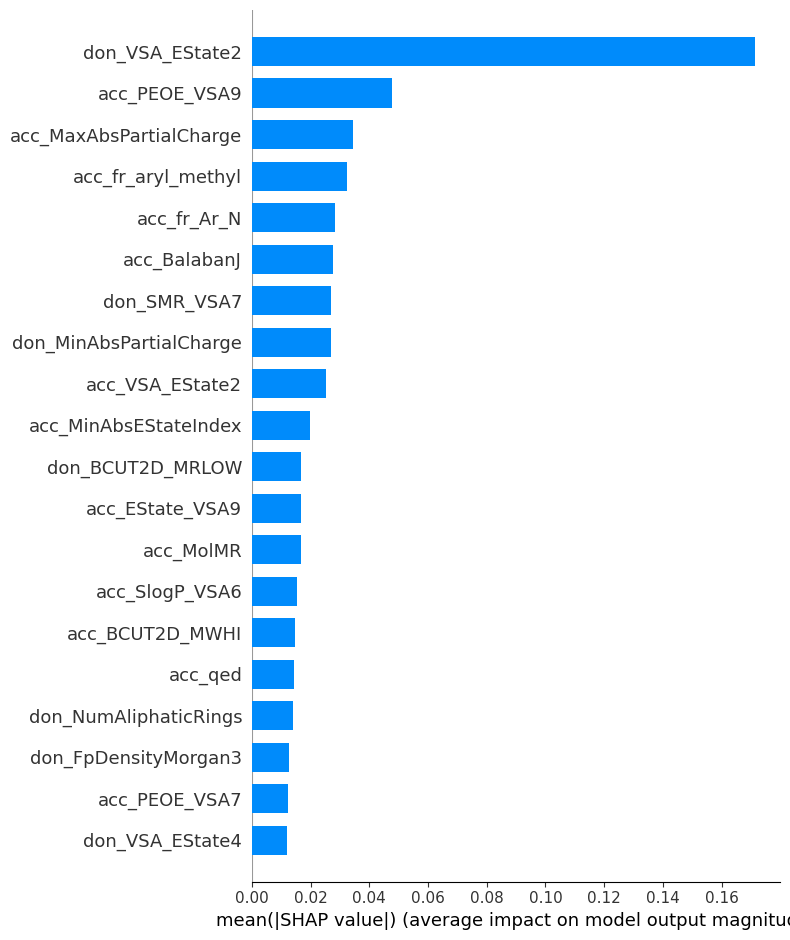

In [ ]:
#  With Random Forest
model = RandomForestRegressor(random_state=42)
model.fit(X_forshap, y_forshap)

explainer = shap.Explainer(model)
shap_values_rf = explainer(X_forshap)

feature_importance_values = shap_values_rf.values
mean_shap_values = np.mean(np.abs(feature_importance_values), axis=0)
feature_names = X_forshap.columns
feature_importance_dict = dict(zip(feature_names, mean_shap_values))
rf_feature_importance_dict = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))


shap.summary_plot(shap_values_rf, X_forshap, plot_type='bar', show=False)

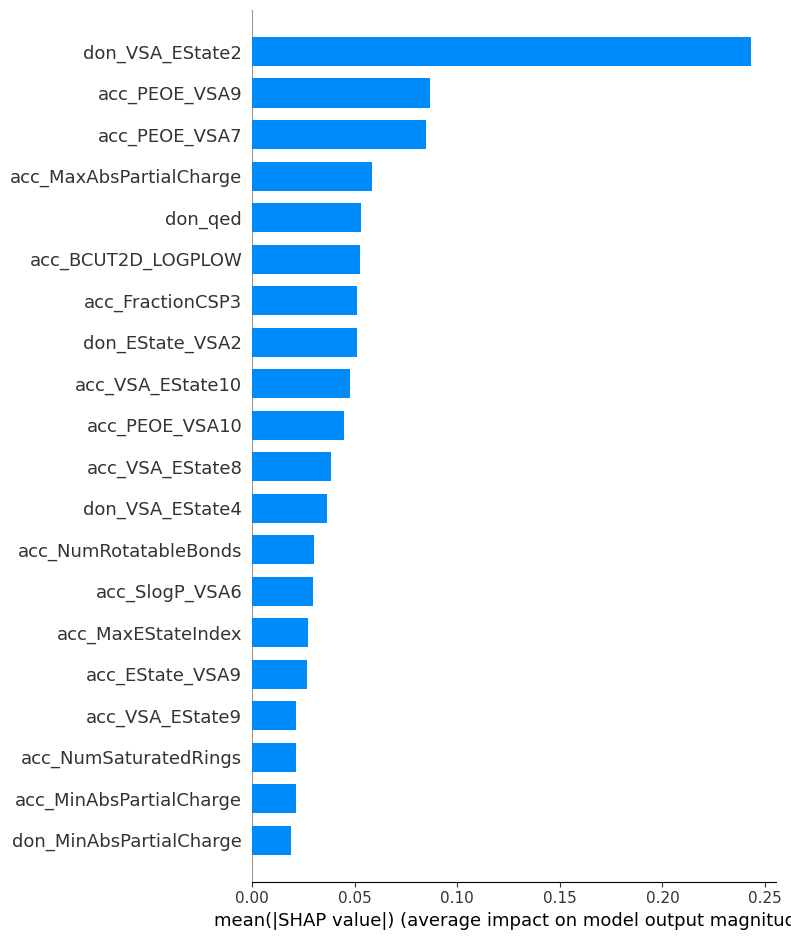

In [ ]:
# With Gradient Bossting
model = GradientBoostingRegressor(random_state=42)
model.fit(X_forshap, y_forshap)

explainer = shap.Explainer(model)
shap_values_gb = explainer(X_forshap)

feature_importance_values = shap_values_gb.values
mean_shap_values = np.mean(np.abs(feature_importance_values), axis=0)
feature_names = X_forshap.columns
feature_importance_dict = dict(zip(feature_names, mean_shap_values))
gb_feature_importance_dict = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

shap.summary_plot(shap_values_gb, X_forshap, plot_type='bar', show=False)


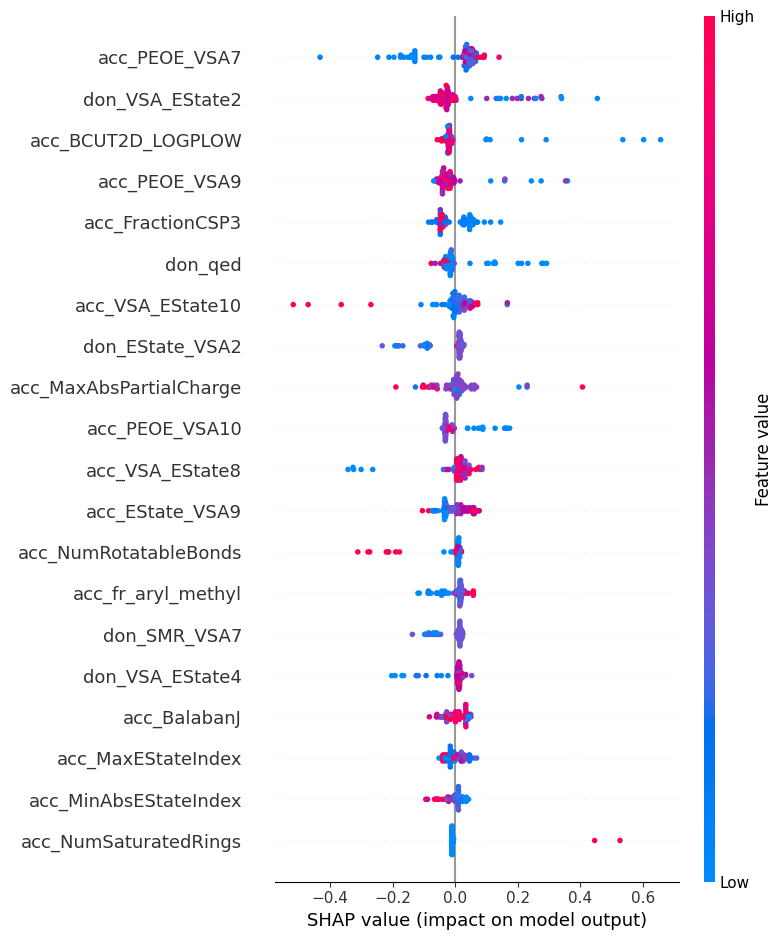

In [ ]:
feature_importance_diff = shap_values_gb - shap_values_rf
# Plot the difference
shap.summary_plot(feature_importance_diff, X_forshap, show=False)

we decide to rank features based on their importance derived from SHAP values and keep the top-ranked features

In [ ]:
mean_abs_shap_values = np.mean(np.abs(feature_importance_diff.values), axis=0)

# Rank features based on mean absolute SHAP values
ranked_features = sorted(zip(X_forshap.columns, mean_abs_shap_values), key=lambda x: x[1], reverse=True)

num_top_features = 15
top_features_to_keep = [feature for feature, _ in ranked_features[:num_top_features]]

print("Top-ranked features to keep:", top_features_to_keep)

Top-ranked features to keep: ['acc_PEOE_VSA7', 'don_VSA_EState2', 'acc_BCUT2D_LOGPLOW', 'acc_PEOE_VSA9', 'acc_FractionCSP3', 'don_qed', 'acc_VSA_EState10', 'don_EState_VSA2', 'acc_MaxAbsPartialCharge', 'acc_PEOE_VSA10', 'acc_VSA_EState8', 'acc_EState_VSA9', 'acc_NumRotatableBonds', 'acc_fr_aryl_methyl', 'don_SMR_VSA7']


# MODEL

In [ ]:
cols = ['Voc', 'Jsc', 'FF','PCE']
X = data_with_descriptors.drop(columns=cols)
y = data_with_descriptors['PCE']

Split data into train and test sets


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X[top_features_to_keep], y, test_size=0.2, random_state=42)

In [ ]:
# data sent for study 1 for comparison purposes
test_data_to_send_for_Study1 = pd.DataFrame(X_test)
test_data_to_send_for_Study1['PCE'] = y_test

test_data_to_send_for_Study1.to_csv('/content/drive/MyDrive/M1_OSCML_PROJECT_2025/test_data_to_send_for_Study2.csv', index=False)

Standardize features

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Define and  Train models

In [ ]:
models = {
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'XGBRegressor': XGBRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'ANN': MLPRegressor(max_iter=1000)
}


param_grids = {
    'DecisionTreeRegressor': {'max_depth': [3, 5, 7]},
    'GradientBoostingRegressor': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]},
    'XGBRegressor': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]},
    'RandomForestRegressor': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]},
    'ANN': {'hidden_layer_sizes': [(50,), (100,), (200,)], 'alpha': [0.0001, 0.001, 0.01]}
}



In [ ]:
np.random.seed(42)

model_names = []
train_r = []
test_r = []
train_mape = []
test_mape = []
train_rmse = []
test_rmse = []

for model_name, model in models.items():
    np.random.seed(42)
    print(f'Training {model_name}...')
    best_score = float('inf')
    best_params = None

    param_grid = param_grids[model_name]

    # Perform grid search without cross-validation
    for params in ParameterGrid(param_grid):
        model.set_params(**params)

        model.fit(X_train_scaled, y_train)
        y_test_pred = model.predict(X_test_scaled)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

        if rmse_test < best_score:
            best_score = rmse_test
            best_params = params

    print(best_params)
    model.set_params(**best_params)
    model.fit(X_train_scaled, y_train)

    y_train_pred = model.predict(X_train_scaled)
    r_train = np.corrcoef(y_train, y_train_pred)[0, 1]
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

    y_test_pred = model.predict(X_test_scaled)
    r_test = np.corrcoef(y_test, y_test_pred)[0, 1]
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    model_names.append(model_name)
    train_r.append(r_train)
    test_r.append(r_test)
    train_mape.append(mape_train)
    test_mape.append(mape_test)
    train_rmse.append(rmse_train)
    test_rmse.append(rmse_test)

    print(f'{model_name} - Training Pearson Correlation Coefficient (r): {r_train:.4f}')
    print(f'{model_name} - Training Mean Absolute Percentage Error (MAPE): {mape_train:.4f}')
    print(f'{model_name} - Training Root Mean Squared Error (RMSE): {rmse_train:.4f}')
    print(f'{model_name} - Testing Pearson Correlation Coefficient (r): {r_test:.4f}')
    print(f'{model_name} - Testing Mean Absolute Percentage Error (MAPE): {mape_test:.4f}')
    print(f'{model_name} - Testing Root Mean Squared Error (RMSE): {rmse_test:.4f}')
    print('\n')



Training DecisionTreeRegressor...
{'max_depth': 3}
DecisionTreeRegressor - Training Pearson Correlation Coefficient (r): 0.6685
DecisionTreeRegressor - Training Mean Absolute Percentage Error (MAPE): 0.0339
DecisionTreeRegressor - Training Root Mean Squared Error (RMSE): 0.6995
DecisionTreeRegressor - Testing Pearson Correlation Coefficient (r): 0.5198
DecisionTreeRegressor - Testing Mean Absolute Percentage Error (MAPE): 0.0454
DecisionTreeRegressor - Testing Root Mean Squared Error (RMSE): 0.9096


Training GradientBoostingRegressor...
{'max_depth': 3, 'n_estimators': 50}
GradientBoostingRegressor - Training Pearson Correlation Coefficient (r): 0.9069
GradientBoostingRegressor - Training Mean Absolute Percentage Error (MAPE): 0.0178
GradientBoostingRegressor - Training Root Mean Squared Error (RMSE): 0.4157
GradientBoostingRegressor - Testing Pearson Correlation Coefficient (r): 0.4411
GradientBoostingRegressor - Testing Mean Absolute Percentage Error (MAPE): 0.0494
GradientBoostingR

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perce

{'alpha': 0.01, 'hidden_layer_sizes': (100,)}
ANN - Training Pearson Correlation Coefficient (r): 0.5439
ANN - Training Mean Absolute Percentage Error (MAPE): 0.0478
ANN - Training Root Mean Squared Error (RMSE): 0.9843
ANN - Testing Pearson Correlation Coefficient (r): -0.0656
ANN - Testing Mean Absolute Percentage Error (MAPE): 0.2534
ANN - Testing Root Mean Squared Error (RMSE): 6.8981




/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


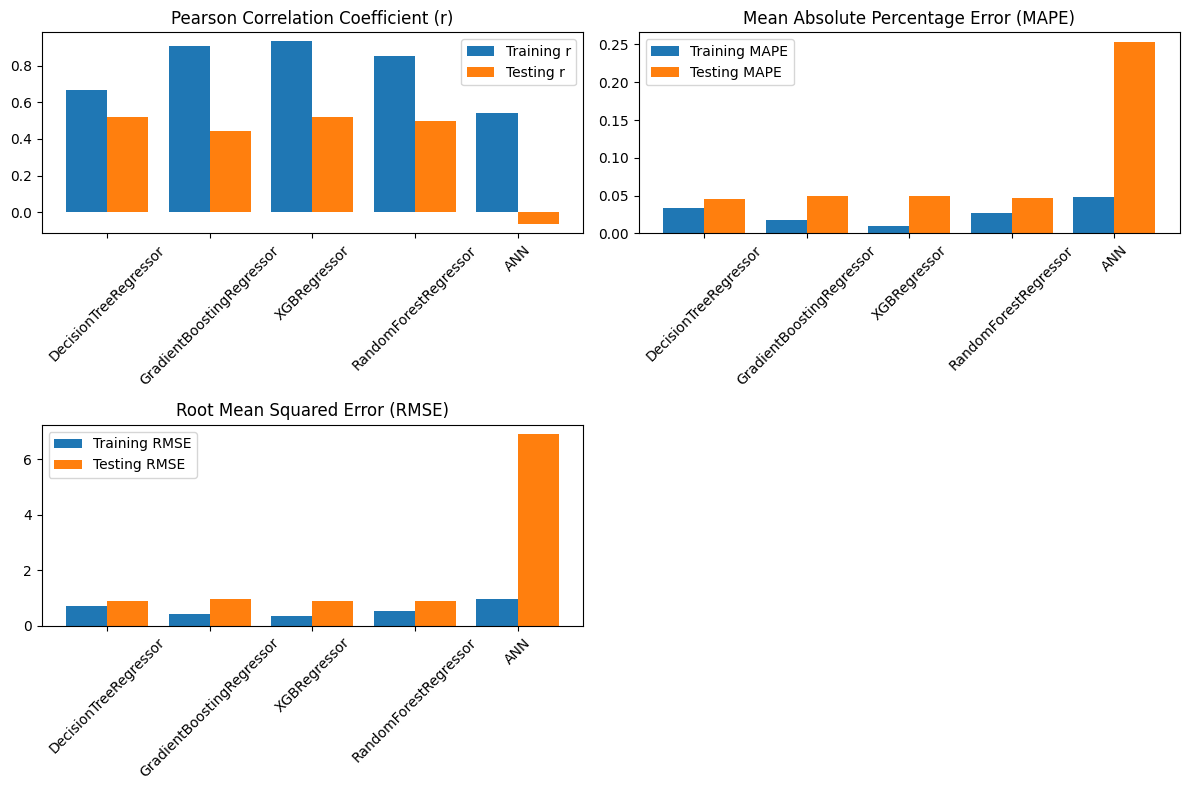

In [ ]:
plt.figure(figsize=(12, 8))

x = np.arange(len(model_names))

plt.subplot(2, 2, 1)
plt.bar(x - 0.2, train_r, width=0.4, label='Training r')
plt.bar(x + 0.2, test_r, width=0.4, label='Testing r')
plt.xticks(x, model_names, rotation=45)
plt.title('Pearson Correlation Coefficient (r)')
plt.legend()

plt.subplot(2, 2, 2)
plt.bar(x - 0.2, train_mape, width=0.4, label='Training MAPE')
plt.bar(x + 0.2, test_mape, width=0.4, label='Testing MAPE')
plt.xticks(x, model_names, rotation=45)
plt.title('Mean Absolute Percentage Error (MAPE)')
plt.legend()

plt.subplot(2, 2, 3)
plt.bar(x - 0.2, train_rmse, width=0.4, label='Training RMSE')
plt.bar(x + 0.2, test_rmse, width=0.4, label='Testing RMSE')
plt.xticks(x, model_names, rotation=45)
plt.title('Root Mean Squared Error (RMSE)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
"""np.random.seed(42)

model_names = []
train_r = []
test_r = []
train_mape = []
test_mape = []
train_rmse = []
test_rmse = []

train_r_std = []
test_r_std = []
train_mape_std = []
test_mape_std = []
train_rmse_std = []
test_rmse_std = []

num_iterations = 10

for model_name, model in models.items():
    np.random.seed(42)
    print(f'Training {model_name}...')

    train_r_iter = []
    test_r_iter = []
    train_mape_iter = []
    test_mape_iter = []
    train_rmse_iter = []
    test_rmse_iter = []

    for _ in range(num_iterations):
        for params in ParameterGrid(param_grids[model_name]):
            model.set_params(**params)
            model.fit(X_train_scaled, y_train)

            y_train_pred = model.predict(X_train_scaled)
            r_train = np.corrcoef(y_train, y_train_pred)[0, 1]
            mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
            rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
            train_r_iter.append(r_train)
            train_mape_iter.append(mape_train)
            train_rmse_iter.append(rmse_train)

            y_test_pred = model.predict(X_test_scaled)
            r_test = np.corrcoef(y_test, y_test_pred)[0, 1]
            mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
            rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
            test_r_iter.append(r_test)
            test_mape_iter.append(mape_test)
            test_rmse_iter.append(rmse_test)

    train_r_mean = np.mean(train_r_iter)
    test_r_mean = np.mean(test_r_iter)
    train_mape_mean = np.mean(train_mape_iter)
    test_mape_mean = np.mean(test_mape_iter)
    train_rmse_mean = np.mean(train_rmse_iter)
    test_rmse_mean = np.mean(test_rmse_iter)

    train_r_std.append(np.std(train_r_iter))
    test_r_std.append(np.std(test_r_iter))
    train_mape_std.append(np.std(train_mape_iter))
    test_mape_std.append(np.std(test_mape_iter))
    train_rmse_std.append(np.std(train_rmse_iter))
    test_rmse_std.append(np.std(test_rmse_iter))

    model_names.append(model_name)
    train_r.append(train_r_mean)
    test_r.append(test_r_mean)
    train_mape.append(train_mape_mean)
    test_mape.append(test_mape_mean)
    train_rmse.append(train_rmse_mean)
    test_rmse.append(test_rmse_mean)

    print(f'{model_name} - Training Pearson Correlation Coefficient (r): {train_r_mean:.4f} ± {train_r_std[-1]:.4f}')
    print(f'{model_name} - Testing Pearson Correlation Coefficient (r): {test_r_mean:.4f} ± {test_r_std[-1]:.4f}')
    print(f'{model_name} - Training Mean Absolute Percentage Error (MAPE): {train_mape_mean:.4f} ± {train_mape_std[-1]:.4f}')
    print(f'{model_name} - Testing Mean Absolute Percentage Error (MAPE): {test_mape_mean:.4f} ± {test_mape_std[-1]:.4f}')
    print(f'{model_name} - Training Root Mean Squared Error (RMSE): {train_rmse_mean:.4f} ± {train_rmse_std[-1]:.4f}')
    print(f'{model_name} - Testing Root Mean Squared Error (RMSE): {test_rmse_mean:.4f} ± {test_rmse_std[-1]:.4f}')
    print('\n')


x_indices = range(len(model_names))

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.bar(x_indices, train_r, yerr=train_r_std, label='Training r')
plt.bar(x_indices, test_r, yerr=test_r_std, label='Testing r')
plt.title('Pearson Correlation Coefficient (r)')
plt.xticks(x_indices, model_names, rotation=45)
plt.legend()

plt.subplot(2, 2, 2)
plt.bar(x_indices, train_mape, yerr=train_mape_std, label='Training MAPE')
plt.bar(x_indices, test_mape, yerr=test_mape_std, label='Testing MAPE')
plt.title('Mean Absolute Percentage Error (MAPE)')
plt.xticks(x_indices, model_names, rotation=45)
plt.legend()

plt.subplot(2, 2, 3)
plt.bar(x_indices, train_rmse, yerr=train_rmse_std, label='Training RMSE')
plt.bar(x_indices, test_rmse, yerr=test_rmse_std, label='Testing RMSE')
plt.title('Root Mean Squared Error (RMSE)')
plt.xticks(x_indices, model_names, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()
"""

"np.random.seed(42)\n\nmodel_names = []\ntrain_r = []\ntest_r = []\ntrain_mape = []\ntest_mape = []\ntrain_rmse = []\ntest_rmse = []\n\ntrain_r_std = []\ntest_r_std = []\ntrain_mape_std = []\ntest_mape_std = []\ntrain_rmse_std = []\ntest_rmse_std = []\n\nnum_iterations = 10\n\nfor model_name, model in models.items():\n    np.random.seed(42)\n    print(f'Training {model_name}...')\n\n    train_r_iter = []\n    test_r_iter = []\n    train_mape_iter = []\n    test_mape_iter = []\n    train_rmse_iter = []\n    test_rmse_iter = []\n\n    for _ in range(num_iterations):\n        for params in ParameterGrid(param_grids[model_name]):\n            model.set_params(**params)\n            model.fit(X_train_scaled, y_train)\n\n            y_train_pred = model.predict(X_train_scaled)\n            r_train = np.corrcoef(y_train, y_train_pred)[0, 1]\n            mape_train = mean_absolute_percentage_error(y_train, y_train_pred)\n            rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred

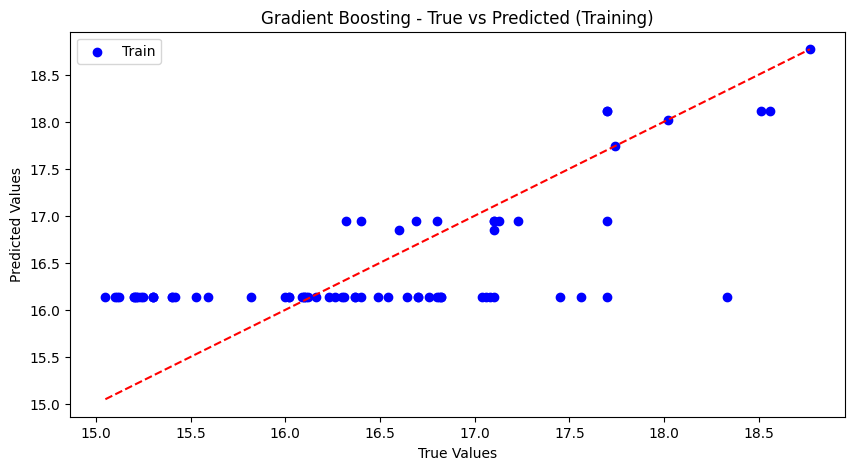

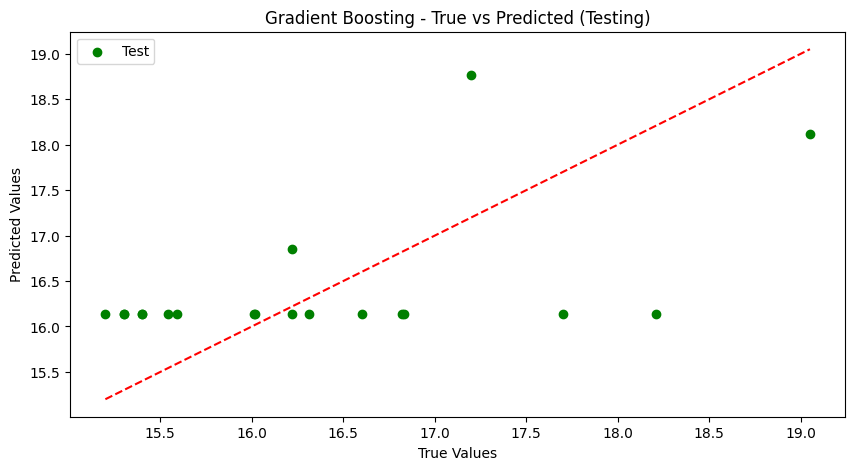

In [ ]:
best_params = {'max_depth': 3}
selected_model = DecisionTreeRegressor(**best_params)

selected_model.fit(X_train_scaled, y_train)
y_train_pred = selected_model.predict(X_train_scaled)
y_test_pred = selected_model.predict(X_test_scaled)

plt.figure(figsize=(10, 5))
plt.scatter(y_train, y_train_pred, color='blue', label='Train')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
plt.title('Decision Trees - True vs Predicted (Training)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_test_pred, color='green', label='Test')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Decision Trees - True vs Predicted (Testing)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

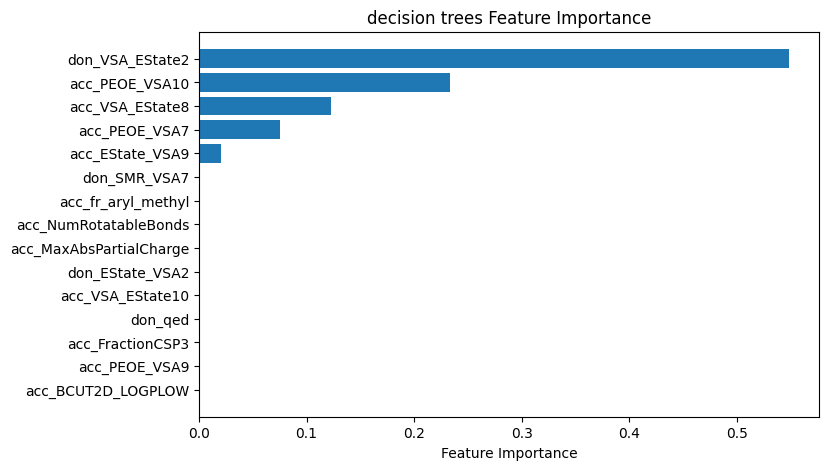

In [ ]:
new_dt_feature_importance = selected_model.feature_importances_


# Plot Feature Importance
plt.figure(figsize=(8, 5))
sorted_indices_dt = np.argsort(new_dt_feature_importance)
plt.barh(range(len(X_train.columns)), new_dt_feature_importance[sorted_indices_dt], align="center")
plt.yticks(range(len(X_train.columns)), X_train.columns[sorted_indices_dt])
plt.xlabel("Feature Importance")
plt.title("decision trees Feature Importance")
plt.show()



# RESULTS ANALYSIS AND CONCLUSION

It appears that the **XGBRegressor** model performs the best on both training and testing data in terms of Pearson Correlation Coefficient, Mean Absolute Percentage Error, and Root Mean Squared Error. However, if interpretability is a concern, DecisionTreeRegressor might be a better choice despite its slightly lower performance metrics. GradientBoostingRegressor also shows strong performance on training data but slightly weaker performance on testing data compared to XGBRegressor.**decision trees** performs well but slightly worse than XGBRegressor on testing data.